# Models

# Model 1 (as in Kaggle.com)

- Label encoder categorical data.

## Import libraries/packages

In [2]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
# from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

##################################

### Metrics ###
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In [3]:
# Load the data.
file = 'car.csv'
data = pd.read_csv(file)

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
buying       1728 non-null object
maint        1728 non-null object
doors        1728 non-null object
persons      1728 non-null object
lug_boot     1728 non-null object
safety       1728 non-null object
class_val    1728 non-null object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
# Shape of the data set.
print("The data set has {} rows and {} columns.".format(
    data.shape[0], data.shape[1]))

The data set has 1728 rows and 7 columns.


In [5]:
# Check for missing values.
data.isna().any()

buying       False
maint        False
doors        False
persons      False
lug_boot     False
safety       False
class_val    False
dtype: bool

In [6]:
# Check for duplicate rows.
data.duplicated().any()

False

In [7]:
# Checking the values from each column.
for col in data.columns:
    print("Column:", col)
    print(data[col].value_counts(), '\n')

Column: buying
vhigh    432
low      432
high     432
med      432
Name: buying, dtype: int64 

Column: maint
vhigh    432
low      432
high     432
med      432
Name: maint, dtype: int64 

Column: doors
3        432
5more    432
4        432
2        432
Name: doors, dtype: int64 

Column: persons
more    576
4       576
2       576
Name: persons, dtype: int64 

Column: lug_boot
big      576
med      576
small    576
Name: lug_boot, dtype: int64 

Column: safety
low     576
high    576
med     576
Name: safety, dtype: int64 

Column: class_val
unacc    1210
acc       384
good       69
vgood      65
Name: class_val, dtype: int64 



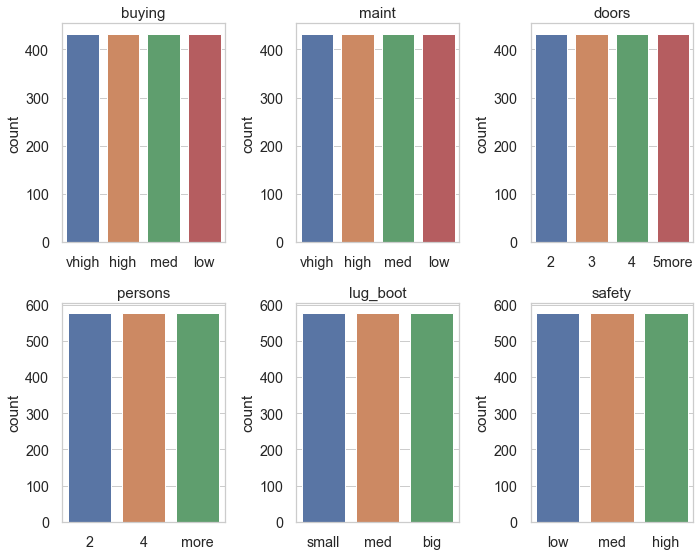

In [29]:
def distploting(df):
    col_value = df.columns.values.tolist()
    sns.set(context='notebook', style='whitegrid',
            font='sans-serif', font_scale=1.3)

    fig, axes = plt.subplots(nrows=2, ncols=3, constrained_layout=True)
    count = 0
    for i in range(2):
        for j in range(3):
            s = col_value[count+j]
            sns.countplot(df[s].values, ax=axes[i][j])
            axes[i][j].set_title(s, fontsize=15)
            fig = plt.gcf()
            fig.set_size_inches(10, 8)
            plt.tight_layout()
        count = count+j+1


distploting(data) #.drop(columns=['class_val'])

Text(0.5, 1.0, 'Class distribution')

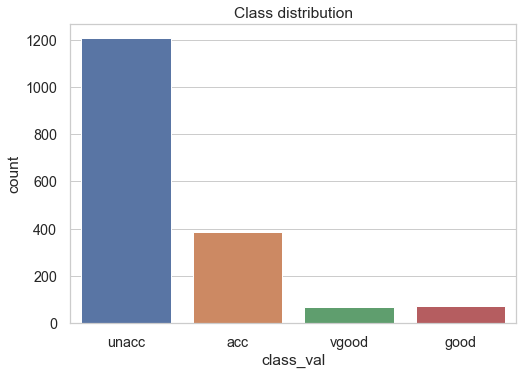

In [31]:
sns.countplot(data['class_val'])
plt.title('Class distribution')

In [8]:
# Plotting the values of each column.
for i in data.columns:
    labels = data[i].unique()
    values = data[i].value_counts()
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    fig.update_layout(title=go.layout.Title(
        text='Value distribution for column: "{}"'.format(i), x=.5))
    fig.show()

Since all the columns are categorical, we change the data types to "category". This will come in handy in case we want to sort any column of the data set.

## Part 2: Preprocessing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [66]:
# Convert categories into integers for each column.
data.buying = data.buying.replace({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3})
data.maint = data.maint.replace({'low': 0, 'med': 1, 'high': 2, 'vhigh': 3})
data.doors = data.doors.replace({'2': 0, '3': 1, '4': 2, '5more': 3})
data.persons = data.persons.replace({'2': 0, '4': 1, 'more': 2})
data.lug_boot = data.lug_boot.replace({'small': 0, 'med': 1, 'big': 2})
data.safety = data.safety.replace({'low': 0, 'med': 1, 'high': 2})
data.class_val = data.class_val.replace(
    {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})

In [67]:
# The data set after the conversion.
data.head()

buying  maint  doors  persons  lug_boot  safety  class_val
0       3      3      0        0         0       0          0
1       3      3      0        0         0       1          0
2       3      3      0        0         0       2          0
3       3      3      0        0         1       0          0
4       3      3      0        0         1       1          0

Text(0.5, 1, 'Correlation matrix')

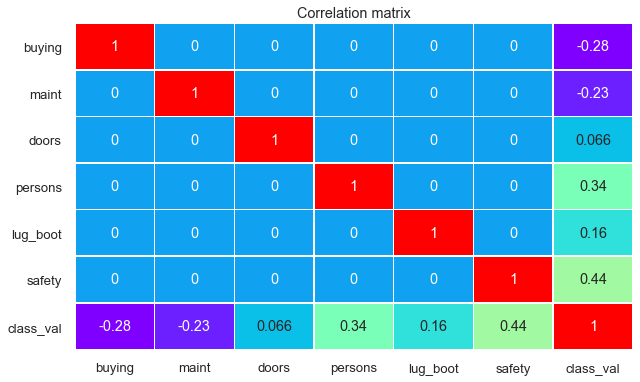

In [68]:
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.heatmap(data.corr(), annot=True, cbar=False, cmap='rainbow', linewidth=0.5)
plt.title('Correlation matrix')

In [69]:
# Choose attribute columns and class column.
X = data[data.columns[:-1]]
y = data['class_val']

In [70]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [71]:
# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network



## Logistic Regression

In [72]:
# Initialize a Logistic Regression classifier.
logreg = LogisticRegression(
    solver='saga', multi_class='auto', random_state=42, n_jobs=-1)

# Train the classifier.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [73]:
# Make predictions.
log_pred = logreg.predict(X_test)

# CV score
logreg_cv = cross_val_score(logreg, X, y, cv=10, n_jobs=-1)

## Metrics for Logistic Regression

In [74]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % logreg_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred, average='macro'))

Accuracy: 0.819
Cross-validation accuracy: 0.779
Precision: 0.707
Recall: 0.643
F1 score: 0.667


## Confusion Matrix for Logistic Regression

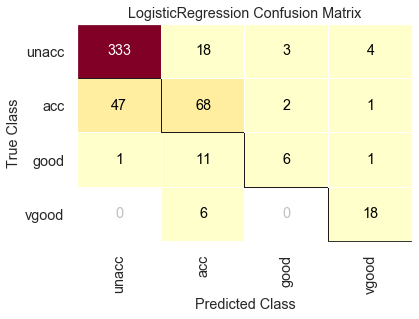

In [75]:
cm = ConfusionMatrix(logreg, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Decision tree

In [76]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(
    max_depth=30, criterion='gini', random_state=42)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Text(0.5, 1.0, 'Decision Tree')

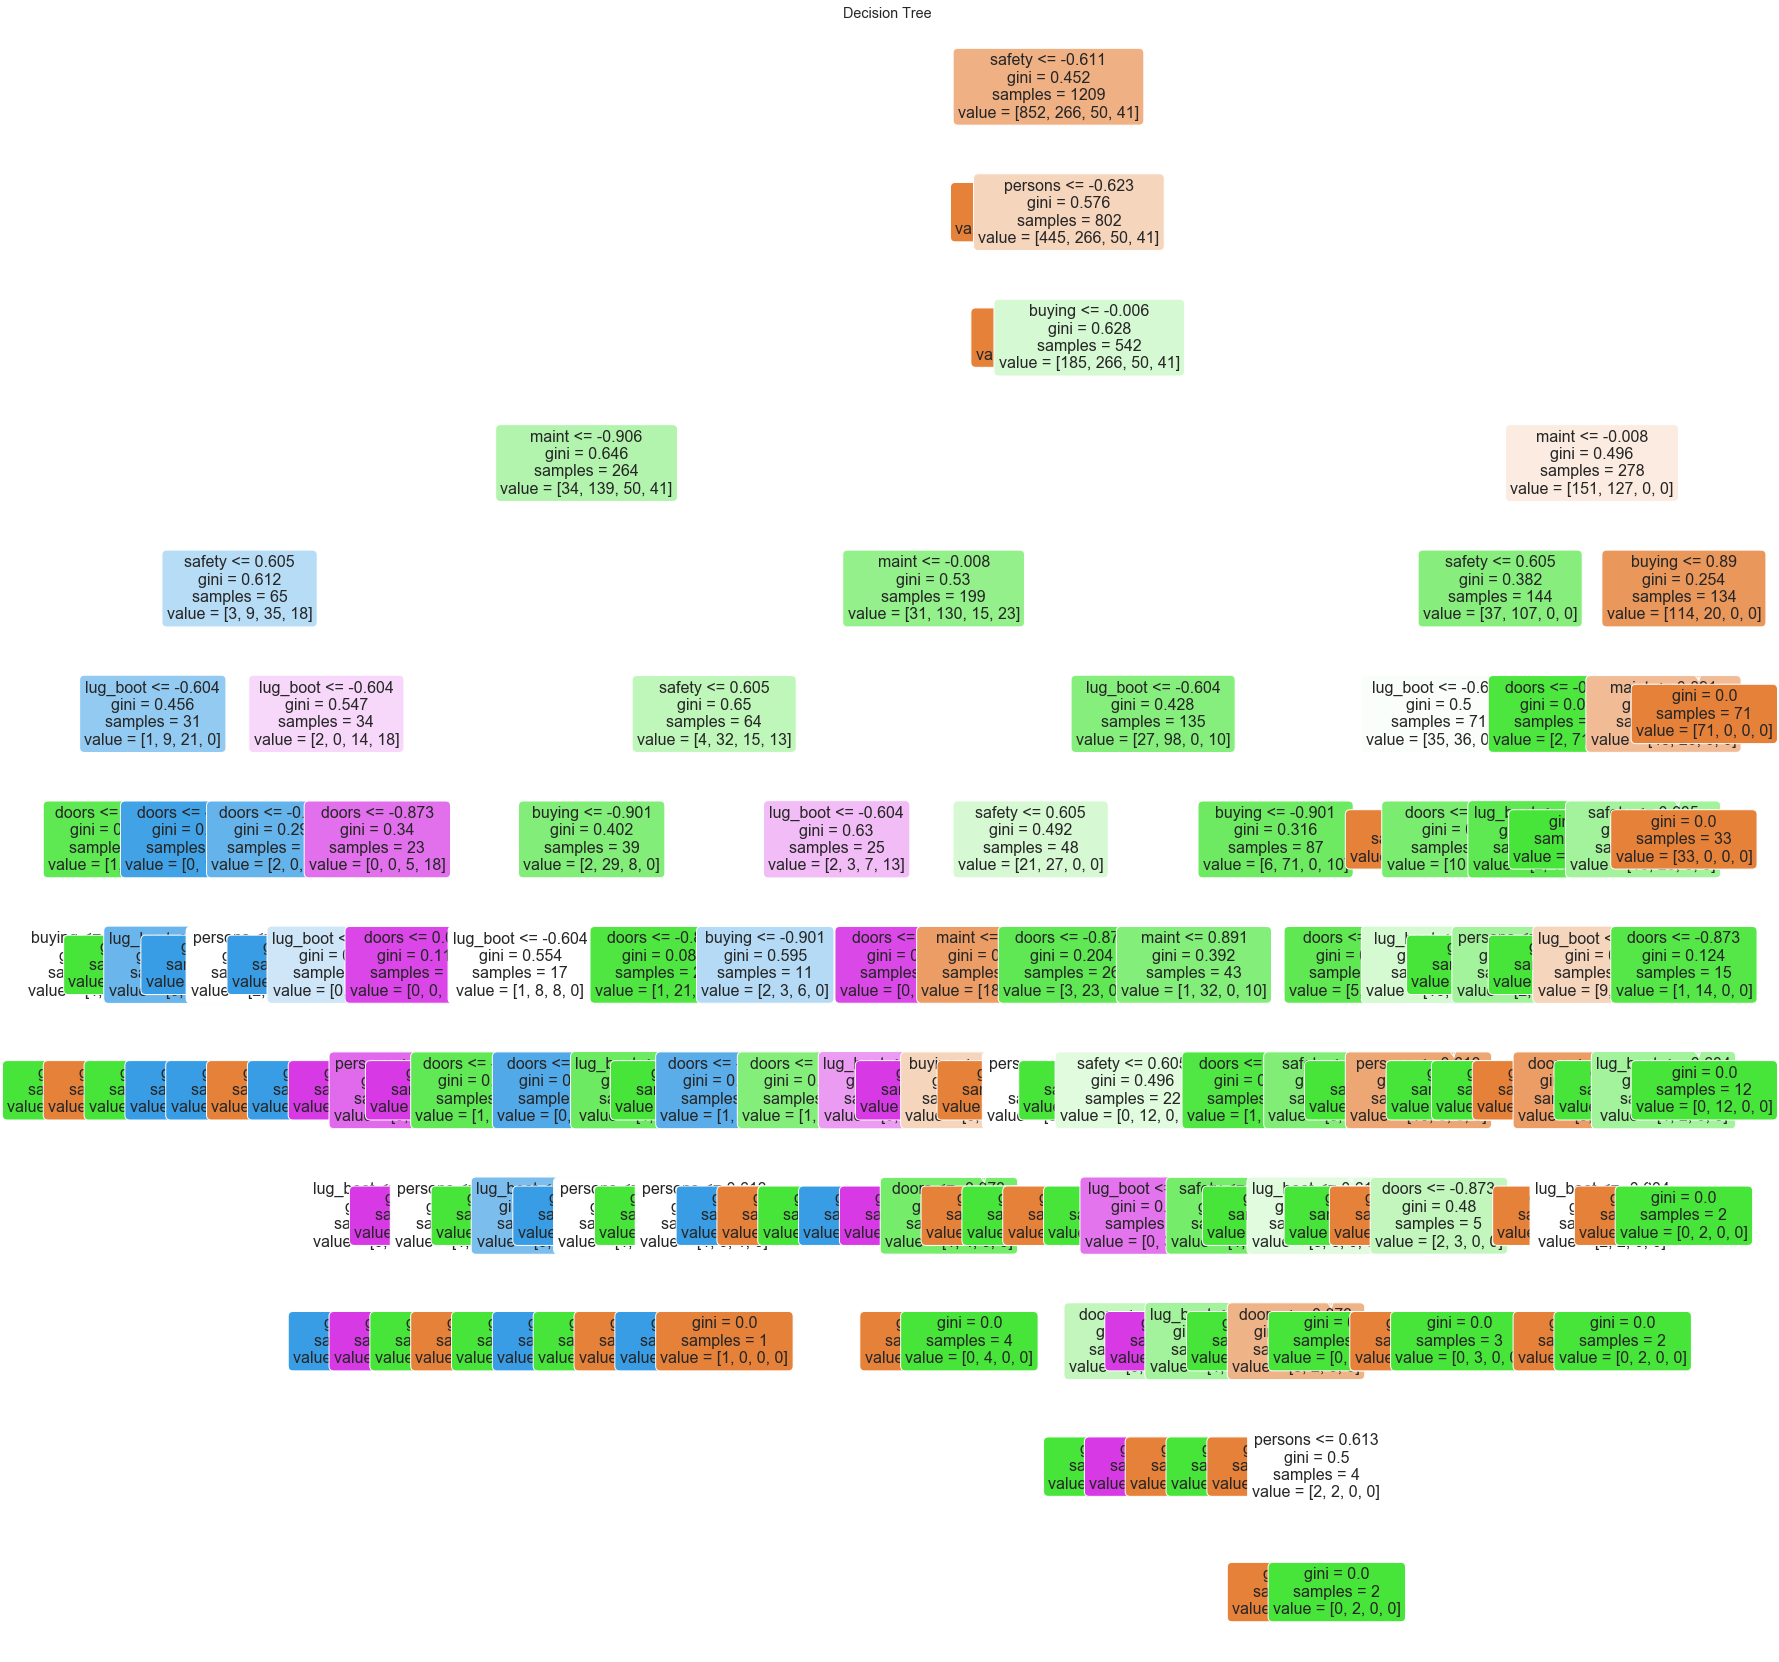

In [77]:
# Plot the tree.
fig = plt.figure(figsize=(30, 30))
tree.plot_tree(tr.fit(X_train, y_train), feature_names=X.columns,
               filled=True, rounded=True, fontsize=16)
plt.title('Decision Tree')

In [78]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- safety <= -0.61
|   |--- class: 0
|--- safety >  -0.61
|   |--- persons <= -0.62
|   |   |--- class: 0
|   |--- persons >  -0.62
|   |   |--- buying <= -0.01
|   |   |   |--- maint <= -0.91
|   |   |   |   |--- safety <= 0.61
|   |   |   |   |   |--- lug_boot <= -0.60
|   |   |   |   |   |   |--- doors <= -0.87
|   |   |   |   |   |   |   |--- buying <= -0.90
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- buying >  -0.90
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- doors >  -0.87
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- lug_boot >  -0.60
|   |   |   |   |   |   |--- doors <= -0.87
|   |   |   |   |   |   |   |--- lug_boot <= 0.61
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- lug_boot >  0.61
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- doors >  -0.87
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |--- safety >  0.61
|   |

In [79]:
# Make predictions.
tr_pred = tr.predict(X_test)

# CV score
tr_cv = cross_val_score(tr, X, y, cv=10, n_jobs=-1)

## Metrics for Decision tree

In [80]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % tr_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred, average='macro'))

# Recall
print('Precision: %.3f' % recall_score(y_test, tr_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred, average='macro'))

Accuracy: 0.967
Cross-validation accuracy: 0.879
Precision: 0.914
Precision: 0.920
F1 score: 0.916


## Confusion Matrix for Decision tree

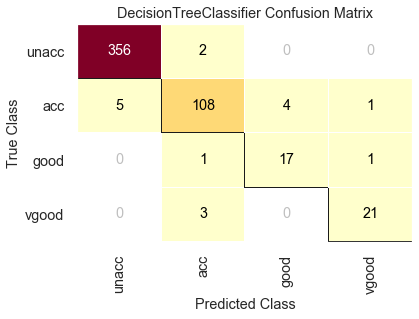

In [81]:
# Print confusion matrix for Decision tree.
cm = ConfusionMatrix(tr, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Neural network (MLP)

In [82]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(5), max_iter=1000,
                    random_state=42, shuffle=True, verbose=False)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [83]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score
mlp_cv = cross_val_score(mlp, X, y, cv=10, n_jobs=-1)

## Metrics for Neural Network (MLP)

In [84]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % mlp_cv.mean())

# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred, average='macro'))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred, average='macro'))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred, average='macro'))

Accuracy: 0.925
Cross-validation accuracy: 0.898
Precision: 0.845
Recall: 0.807
F1 score: 0.815


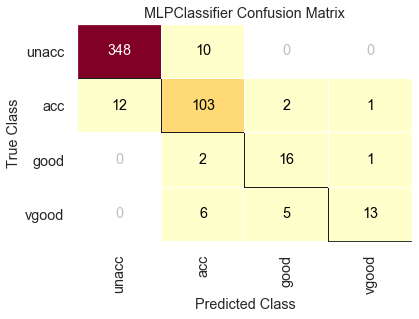

In [85]:
# Plot confusion matrix for MLP.
cm = ConfusionMatrix(mlp, classes=['unacc', 'acc', 'good', 'vgood'],
                     label_encoder={0: 'unacc', 1: 'acc', 2: 'good', 3: 'vgood'}, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

## Results

In [86]:
metrics = ['Accuracy', 'CV accuracy', 'Precision', 'Recall', 'F1', 'AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test), logreg_cv.mean(), precision_score(y_test, log_pred, average='macro'), recall_score(y_test, log_pred, average='macro'), f1_score(y_test, log_pred, average='macro')]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test), tr_cv.mean(), precision_score(y_test, tr_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), f1_score(y_test, tr_pred, average='macro')]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test), mlp_cv.mean(), precision_score(y_test, mlp_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]),
])

fig.update_layout(title_text='Metrics for all models',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

In [87]:
d = {
    'Models': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [logreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)],
    'CV Accuracy': [logreg_cv.mean(), tr_cv.mean(), mlp_cv.mean()],
    'Precision': [precision_score(y_test, log_pred, average='macro'), precision_score(y_test, tr_pred, average='macro'), precision_score(y_test, mlp_pred, average='macro')],
    'Recall': [recall_score(y_test, log_pred, average='macro'), recall_score(y_test, tr_pred, average='macro'), recall_score(y_test, mlp_pred, average='macro')],
    'F1': [f1_score(y_test, log_pred, average='macro'), f1_score(y_test, tr_pred, average='macro'), f1_score(y_test, mlp_pred, average='macro')]
}

results = pd.DataFrame(data=d).round(3).set_index('Models')
results

Accuracy  CV Accuracy  Precision  Recall     F1
Models                                                               
Logistic Regression      0.819        0.779      0.707   0.643  0.667
Decision Tree            0.967        0.879      0.914   0.920  0.916
Neural Network (MLP)     0.925        0.898      0.845   0.807  0.815

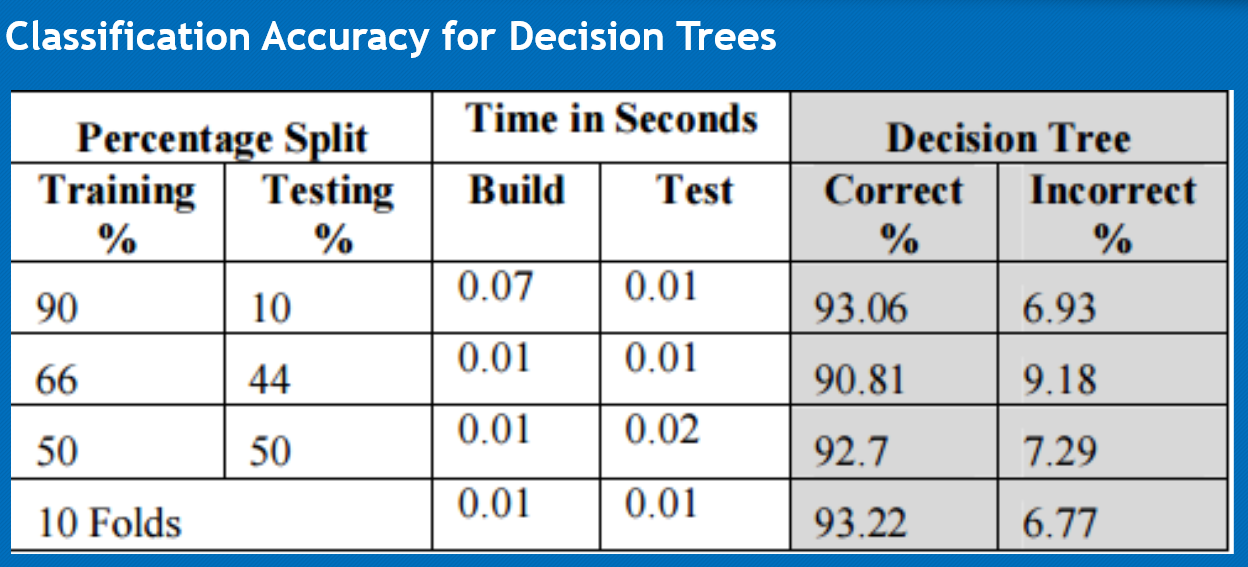

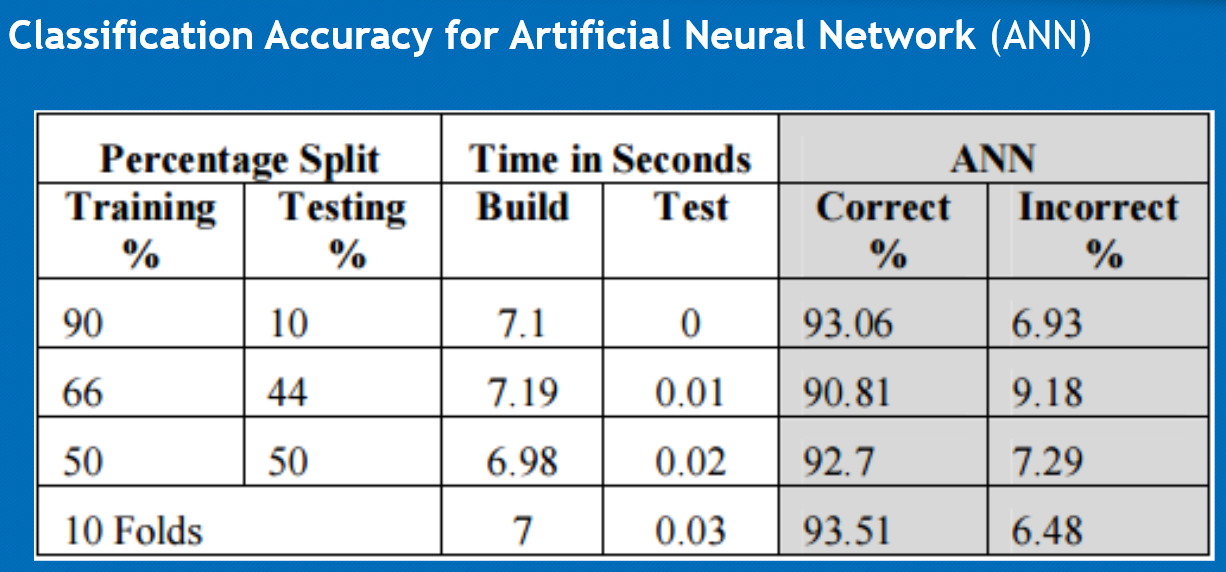

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Error rate $E_{1}$ for model $M_{1}$ on test set $A$.
- Error rate $E_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|E_{1}-E_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.

In [30]:
from itertools import combinations

# Dictionary with all the classifiers.
models = {'LogisticRegression': logreg,
          'DecisionTreeClassifier': tr,
          'MLPClassifier': mlp
          }


def evaluating_performance2(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            E1 = models[model[0]].score(X_test, y_test)
            E2 = models[model[1]].score(X_test, y_test)
            var1 = E1*(1-E1)
            var2 = E2*(1-E2)
            n = len(X_test)
            P = abs(E1-E2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'==>The models {model[0]} and {model[1]} are significant different<==\n')


evaluating_performance2(models)

Comparing Performance between LogisticRegression and DecisionTreeClassifier: 8.111
==>The models LogisticRegression and DecisionTreeClassifier are significant different<==

Comparing Performance between LogisticRegression and MLPClassifier: 5.173
==>The models LogisticRegression and MLPClassifier are significant different<==

Comparing Performance between DecisionTreeClassifier and MLPClassifier: 3.203
==>The models DecisionTreeClassifier and MLPClassifier are significant different<==

